In [1]:
import os
from os.path import isfile, join, basename
from pathlib import Path

from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
!ls

FIJI_scripts
HPAv18_ImCompare.py
HPAv18_duplicate_image_detection.ipynb
HPAv18_external_data_download.ipynb
HPAv18_find_dupes_multiproc.py
HPAv18_multiproc_download_AWS.py
Hirano3D_data_handling_v1.ipynb
Hirano3D_v1_Res18_local_v1.ipynb
Hirano3D_v1_Res18_local_v2.ipynb
Hirano3D_v1_dn121_local_8bit_GRFB_v2.ipynb
Hirano3D_v1_dn121_local_v1.ipynb
Kaggle_Data_handling.ipynb
Kaggle_Data_handling_save.ipynb
Kaggle_HPA_First_model_AWS_v1.1.ipynb
Kaggle_HPA_First_model_WP.ipynb
Kaggle_HPA_First_model_WP_v1.0.ipynb
Kaggle_HPA_First_model_WP_v1.1.ipynb
Kaggle_HPA_First_model_WP_v2_BGR.ipynb
Kaggle_HPA_First_model_WP_v3_BGR_AWS.ipynb
Kaggle_HPA_First_model_WP_v3_BGR_local.ipynb
Local
MDA_data.ipynb
MDA_grant_data
MNIST_to_jpg.ipynb
MNIST_trials.ipynb
Old_nbs
YNet_Res_Pretrained.ipynb
__pycache__
common
datasets
dudethefile.txt
examples
models
pathhaystack_no_si.csv
pathneedles.csv
pytorch_t
resources
yeast_v11.1_ResNet34_1.1-WIP_Leon.ipynb
yeast_v11.1_per_class.dict.per_class.dict
yeast_v11.3_Res

In [3]:
yeast_mito_dist = pd.read_csv('MDA_grant_data/Yeast_distribution_features.csv', header=None)
yeast_mito_x, yeast_mito_y = yeast_mito_dist.values[:,:4], yeast_mito_dist.values[:,5]
yeast_mito_y.shape

(665,)

In [4]:
pd.Series(yeast_mito_y).value_counts()

0.0    190
1.0    166
4.0    118
3.0    111
2.0     80
dtype: int64

In [5]:
classes = {0: 'WT', 1: 'mfb1KO', 2: 'mmr1KO', 3: 'DKO', 4: 'num1KO'}

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [7]:
def plot_embeddings(x, y, classes):

    fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
    compA = 0
    compB = 1

    for i in range(len(classes.keys())):
        trn_UMAP_cls = x[y == i]

        axarr.scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = classes[i], s = 5)
        axarr.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
# running PCA:
pca = []
n_components = 2
pca = PCA(n_components)

trn_pca_result = pca.fit_transform(yeast_mito_x)

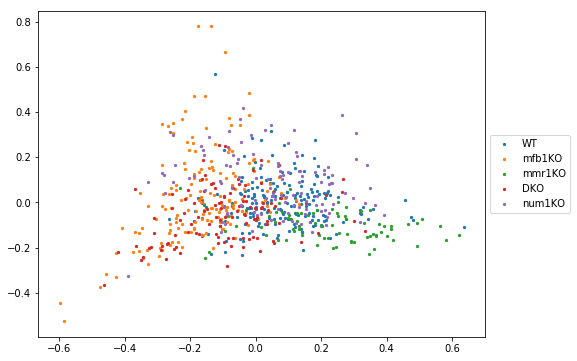

In [9]:
plot_embeddings(trn_pca_result, yeast_mito_y, classes)

In [ ]:
# running TSNE:

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(yeast_mito_x)

In [ ]:
tsne_results.shape

In [ ]:
plot_embeddings(tsne_results, yeast_mito_y, classes)

In [ ]:
# running UMAP:

UMAP_trn_embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.6,
                      metric='correlation').fit(yeast_mito_x)

UMAP_trn = UMAP_trn_embedding.embedding_

In [ ]:
plot_embeddings(UMAP_trn, yeast_mito_y, classes)

In [12]:
from resources.plots import *

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



In [13]:
def SVM_fitter(x, y, classes):

    # #############################################################################
    # Train a SVM classification model
    
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=1)
    
    
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
    
    y_pred = clf.predict(X_test)
    
    print("done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=classes.values()))
    print(accuracy_score(y_test, y_pred))

    cm = confusion_matrix(y_pred,y_test)
    plot_confusion_matrix(cm, classes.values())
    
    return clf, y_test, y_pred

Fitting the classifier to the training set
done in 1.914s
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 1.921s
             precision    recall  f1-score   support

         WT       0.59      0.58      0.59        96
     mfb1KO       0.64      0.71      0.67        78
     mmr1KO       0.66      0.66      0.66        47
        DKO       0.49      0.53      0.51        59
     num1KO       0.48      0.38      0.42        53

avg / total       0.58      0.58      0.58       333

0.5795795795795796
[[56  6  9  7 17]
 [ 7 55  1 15  8]
 [12  0 31  3  1]
 [ 9 13  3 31  7]
 [12  4  3  3 20]]


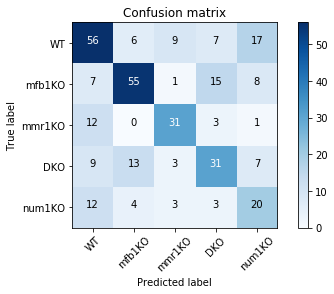

In [14]:
SVM_raw, test_targs, test_preds = SVM_fitter(yeast_mito_x, yeast_mito_y, classes)